## mimlsvm

mi = mulit-instance
ml = multi-label
svm = svm

As described in Shen et al 2009: http://ieeexplore.ieee.org/document/5346261/

good params: {'svm_degree': 3, 'svm_kernel': 'poly', 'medoid_normalization': None, 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto', 'vectorizer_norm': None, 'svm_c': 1}

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import nltk
import os
import re
import pickle
import sklearn
import sys
import string
import warnings

from nltk import TextTilingTokenizer

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler,MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.svm import SVC

from joblib import Parallel, delayed

from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [3]:
%aimport src.data.movielens_20m_imdb
%aimport src.helpers.labels,src.helpers.neighbours, src.helpers.segments,src.helpers.embeddings
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics, src.utils.distances, src.utils.plotting

In [4]:
from src.data.movielens_20m_imdb import load_df_or_get_from_cache
from src.helpers.labels import truncate_labels
from src.helpers.segments import make_distance_matrix_for_segments,vectorize_segments
from src.helpers.embeddings import read_glove_wiki_weighted

from src.utils.dataframes import sample_rows
from src.utils.metrics import ranking
from src.utils.clusters import k_medoids
from src.utils.distances import hausdorff
from src.utils.plotting import plot_micro_f1_at_k

In [6]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/movielens-mimlsvm-embeddings/")
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/movielens-ml20m-imdb/")
PATH_TO_PROCESSED_FILE = os.path.abspath('../../../data/processed/movielens-20m-imdb-tags-and-synopses-2017-12-20.csv')

# CONFIGS

SEED= 42
W=20 # Pseudosentence size (in words) - not specified in the paper, taken from TextTiling default values
K=10 # Size (in sentences) of the block used in the block comparison method - not specified in the paper, taken from TextTiling default values
MAX_NB_WORDS=500
EMBEDDINGS_DIM=100
SAMPLE_FRAC= 0.3

In [ ]:
docs_df = load_df_or_get_from_cache(PATH_TO_PROCESSED_FILE,INTERIM_DATA_ROOT)

In [ ]:
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [ ]:
docs_df['sentences'] = docs_df['synopsis'].map(lambda row: sentence_tokenizer.tokenize(row))

In [ ]:
%%time
docs_df['num_sentences'] = docs_df['sentences'].map( lambda sents: len(sents))

In [ ]:
docs_df.head()

In [ ]:
docs_df.iloc[0]['sentences'][:5]

In [ ]:
docs_df.describe()

In [ ]:
tok = TextTilingTokenizer(w=W, k=K)

In [ ]:
def extract_segments(candidates):
    
    try:
        # we must manually insert "\n\n" because this is how 
        # texttilingtokenizer requires candidate boundaries to be 
        # represented.
        segments = tok.tokenize("\n\n".join(candidates))
    except ValueError:
        # this happens when the candidate list is too small for the 
        # text tiling tokenizer to be able to find segments. so just return
        # the original sentences.
        segments= candidates
        
    # now remove the artificially added chars
    segments = [segment.replace("\n\n"," ").strip() for segment in segments]
    
    return segments

In [7]:
if os.path.isfile(INTERIM_DATA_ROOT+"/docs_df_with_segments-{}.p".format(MAX_NB_WORDS)):
    print('cache hit')
    docs_df = pickle.load(open(INTERIM_DATA_ROOT+"/docs_df_with_segments-{}.p".format(MAX_NB_WORDS),"rb"))
else:
    docs_df['segments'] = docs_df['sentences'].map(lambda candidates: extract_segments(candidates))
    pickle.dump(docs_df,open(INTERIM_DATA_ROOT+"/docs_df_with_segments-{}.p".format(MAX_NB_WORDS),"wb"))

cache hit


### sample for grid search

In [8]:
sample_df = docs_df.sample(int(SAMPLE_FRAC*len(docs_df)))

In [9]:
segments = sample_df['segments'].values
documents = sample_df['synopsis'].values
labels = sample_df["tags"].map(lambda tagstring: tagstring.split(","))

In [10]:
labels = truncate_labels(labels,10)

In [11]:
# segments, documents and labelsets are defined outside of the parameterGrid loop
# because they're the same for every configuration    
segments_train, segments_val, documents_train, documents_val, Y_train, Y_val = train_test_split(segments,
                                                                                               documents,
                                                                                               labels,
                                                                                               test_size=0.15)

mlb = MultiLabelBinarizer()
mlb.fit(labels)

Y_train = mlb.transform(Y_train)
Y_val = mlb.transform(Y_val)

print('total number of train documents: {}'.format(len(documents_train)))
print('total number of validation documents: {}'.format(len(documents_val)))
print("total number of unique tags: {} ".format(len(mlb.classes_)))

total number of train documents: 1711
total number of validation documents: 302
total number of unique tags: 619 


In [ ]:
vect = TfidfVectorizer(max_features=MAX_NB_WORDS)
vect.fit(documents)

feature_names = vect.get_feature_names()
idf = vect.idf_
idf_index = dict(zip(vect.get_feature_names(), idf))

In [ ]:
# analyzer = preprocess + tokenize
tokenize_func = vect.build_analyzer()

def tokenize(string):
    return tokenize_func(string)

In [ ]:
%%time
X_train_tok = list()

for document_segments in segments_train:
    tokenized_segments = [tokenize(segment) for segment in document_segments]
    X_train_tok.append(tokenized_segments)

In [ ]:
%%time
X_val_tok = list()

for document_segments in segments_val:
    tokenized_segments = [tokenize(segment) for segment in document_segments]
    X_val_tok.append(tokenized_segments)

### transform into embeddings

In [ ]:
embeddings_index = read_glove_wiki_weighted(
    d=EMBEDDINGS_DIM,
    weight_index=idf_index)

In [ ]:
def build_bag_of_weighted_embeddings(tokens): 
    out = [embeddings_index[token] for token in tokens if token in embeddings_index.keys()]
    return np.mean(np.array(out),axis=0)    

In [12]:
cache_path = INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm-embeddings/X_train_boe_segments-sample-{}.p".format(SAMPLE_FRAC)

if os.path.isfile(cache_path):
    print('cache hit')
    X_train_boe_segments = pickle.load(open(cache_path,'rb'))
else:
    X_train_boe_segments = list()

    for tokenized_document_segments in X_train_tok:
        document_segments_boe = list()

        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            for seg in tokenized_document_segments:
                if len(seg) == 0:
                    print('empty segment')
                    continue
                else:
                    try:
                        boe=build_bag_of_weighted_embeddings(seg)
                    except RuntimeWarning:
                        print('segment entirely with OOV words')
                        continue

                    document_segments_boe.append(boe)

        X_train_boe_segments.append(document_segments_boe)

    pickle.dump(X_train_boe_segments,open(cache_path,"wb"))

cache hit


In [13]:
cache_path = INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm-embeddings/X_val_boe_segments-sample-{}.p".format(SAMPLE_FRAC)

if os.path.isfile(cache_path):
    print('cache hit')
    X_val_boe_segments = pickle.load(open(cache_path,'rb'))
else:
    X_val_boe_segments = list()

    for tokenized_document_segments in X_val_tok:
        document_segments_boe = list()

        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            for seg in tokenized_document_segments:
                if len(seg) == 0:
                    print('empty segment')
                    continue
                else:
                    try:
                        boe=build_bag_of_weighted_embeddings(seg)
                    except RuntimeWarning:
                        print('segment entirely with OOV words')
                        continue

                    document_segments_boe.append(boe)

        X_val_boe_segments.append(document_segments_boe)

    pickle.dump(X_val_boe_segments,open(cache_path,"wb"))

cache hit


In [14]:
def make_distance_matrix_for_embedding_segments(vectorized_segments, distance='hausdorff'):
    """
    Returns the distance matrix for the documents having the given segments.

    :param vectorized_segments: array of size M, where each element is a "bag" of segments: matrix of
        shape (*,NUM_FEATURES), and each row on this matrix is the TF-IDF vector for one segment.
    :param distance: how to compare the two bags
    :return: pairwise distance matrix (MxM matrix)
    """
    if distance.lower().strip() != 'hausdorff':
        raise Exception("Only 'hausdorff' distance supported right now.")

    num_samples = len(vectorized_segments)

    distance_function = lambda a, b: hausdorff(a, b)

    distance_matrix = np.zeros((num_samples, num_samples))

    for i, segments_for_document_a in enumerate(vectorized_segments):
        for j, segments_for_document_b in enumerate(vectorized_segments):
            distance = distance_function(segments_for_document_a, segments_for_document_b)
            distance_matrix[i][j] = distance

    return distance_matrix

In [15]:
%%time

path_to_cache = INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm-embeddings/distance-matrix-train-sample-{}.p".format(SAMPLE_FRAC)

if os.path.isfile(path_to_cache):
    print('cache hit')
    dist_matrix_train = pickle.load(open(path_to_cache,"rb"))
else:
    print('Fitting distance matrix')
    dist_matrix_train = make_distance_matrix_for_embedding_segments(X_train_boe_segments)
    pickle.dump(dist_matrix_train, open(path_to_cache, "wb"))

cache hit
CPU times: user 12 ms, sys: 32 ms, total: 44 ms
Wall time: 515 ms


In [16]:
def make_train_dataset(distance_matrix, medoid_indices):
    """
    Returns a matrix where element Aij contains the distance from sample i to medoid j.

    :param distance_matrix: MxM matrix with pairwise distances
    :param medoid_indices: array of length N containing the indices of the medoids for each cluster
    :return: distances to medoids (MxN matrix)
    """

    return distance_matrix[:,medoid_indices]

In [17]:
def make_validation_dataset(source_vectorized_segments, medoid_vectorized_segments):
    """
    Calculates the distances from every source_document (reprsented by its segments) to every medoid
    document (also represented by its segments) using the hausdorff distance.
    
    Returns a matrix where element Aij contains the distance from sample i to medoid j.

    :param source_vectorized_segments: array of length M, where each element is a matrix with one row
        for every segment in a source document
    :param medoid_vectorized_segments: array of length N where each element is a matrix with one row
        for every segment in a medoid document
    :return: distances to medoids (MxN matrix)
    """
    
    num_val_samples = len(source_vectorized_segments)
    num_medoids = len(medoid_vectorized_segments)
    
    val_dataset = np.zeros((num_val_samples,num_medoids))    
    
    for i,source_segments in enumerate(source_vectorized_segments):
        for j,medoid_segments in enumerate(medoid_vectorized_segments):
            val_dataset[i][j] = hausdorff(source_segments,medoid_segments)
            
    return np.array(val_dataset)

In [18]:
# calculating medoids
NORMALIZATION = ['standard','minmax',None] # not specified in the paper
SAMPLE_TO_NB_MEDOIDS_RATIO = [0.2,0.3,0.4] # not specified in the paper, but taken from MIMLSVM canonical implementation
# classification
SVM_KERNEL=['rbf','linear','poly'] # not specified in the paper, but taken from MIMLSVM canonical implementation
SVM_GAMMA=['auto'] # not specified in the paper, but taken from MIMLSVM canonical implementation
SVM_C= [0.1,1,10]# not specified in the paper, but taken from MIMLSVM canonical implementation
SVM_DEGREE=[3,4,5]

In [19]:
grid_search_parameters = [
    {
        'medoid_normalization':  NORMALIZATION,
        'svm_kernel': ['poly'],
        'svm_c':SVM_C,
        'svm_degree' :SVM_DEGREE,
        'svm_gamma':SVM_GAMMA,
        'nb_medoids_ratio': SAMPLE_TO_NB_MEDOIDS_RATIO
    },
    {
        'medoid_normalization':  NORMALIZATION,
        'svm_kernel': ['rbf'],
        'svm_c':SVM_C,
        'svm_degree' :[None],
        'svm_gamma':SVM_GAMMA,
        'nb_medoids_ratio': SAMPLE_TO_NB_MEDOIDS_RATIO
    },
    {
        'medoid_normalization':  NORMALIZATION,
        'svm_kernel': ['linear'],
        'svm_c':SVM_C,
        'svm_gamma':SVM_GAMMA,
        'svm_degree' :[None],
        'nb_medoids_ratio': SAMPLE_TO_NB_MEDOIDS_RATIO
    }
]

In [20]:
print('total number of configurations to test: {}'.format(len(ParameterGrid(grid_search_parameters))))

total number of configurations to test: 135


In [24]:
import warnings
warnings.filterwarnings('ignore')

for (i,configuration) in tqdm(enumerate(ParameterGrid(grid_search_parameters))):
                 
    # nb_medoids depends upon the dataset length
    ratio = configuration['nb_medoids_ratio']
    nb_medoids = int(len(documents_train) * ratio)
    
    # these are the document segments to be used as medoids
    medoids_indices_train = k_medoids(dist_matrix_train,nb_medoids)[0]

    # a matrix where element Aij contains the distance from sample i to medoid j.
    X_train = make_train_dataset(dist_matrix_train,medoids_indices_train)
    
    # VALIDATION SET

    fitted_medoids = list()
    for medoid_index in medoids_indices_train:
        fitted_medoids.append(X_train_boe_segments[medoid_index]) 
    
    X_val = make_validation_dataset(X_val_boe_segments,fitted_medoids)     
        
    svm = SVC(kernel=configuration['svm_kernel'],
            gamma=configuration['svm_gamma'],
            C=configuration['svm_c'],
            degree=configuration['svm_degree'])
    
    clf = OneVsRestClassifier(CalibratedClassifierCV(svm,cv=2),n_jobs=-1)        

    if configuration['medoid_normalization'] == 'standard':      
        scaler = StandardScaler()
        X_train_final = scaler.fit_transform(X_train)
        X_val_final = scaler.transform(X_val)
    elif configuration['medoid_normalization'] == 'minmax':
        scaler = MinMaxScaler()
        X_train_final = scaler.fit_transform(X_train)
        X_val_final = scaler.transform(X_val)
    else:
        X_train_final = X_train
        X_val_final = X_val
    
    # y_train was defined outside the loop    
    clf.fit(X_train,Y_train)
    
    # train score
    Y_pred_train = clf.predict_proba(X_train)
    
    # validation score
    Y_pred_val = clf.predict_proba(X_val)  
    
    print("iter: {}, configuration: {}\n".format(i,configuration))
    
    ks = [1,2,3,4,5,6,7,8,9,10]

    for k in ks:
#         print("train micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_train,Y_pred_train,k=k,normalize=True)))
        print("validation micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=k,normalize=True)))    


0it [00:00, ?it/s]
1it [02:14, 134.20s/it]

iter: 0, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.19701492537313434
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18072289156626506
validation micro-F1 @6: 0.1779788838612368
validation micro-F1 @7: 0.17837139164153382
validation micro-F1 @8: 0.17384731670445955
validation micro-F1 @9: 0.17461383478844864
validation micro-F1 @10: 0.16858702243784113


2it [04:30, 134.78s/it]

iter: 1, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.18345864661654135
validation micro-F1 @3: 0.18981018981018982
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18400481058328322
validation micro-F1 @6: 0.17980914113510799
validation micro-F1 @7: 0.17680034497628289
validation micro-F1 @8: 0.17039000378644453
validation micro-F1 @9: 0.17338709677419356
validation micro-F1 @10: 0.16858702243784113


3it [06:57, 138.62s/it]

iter: 2, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19970193740685543
validation micro-F1 @3: 0.18981018981018982
validation micro-F1 @4: 0.18482344102178813
validation micro-F1 @5: 0.1829121540312876
validation micro-F1 @6: 0.17706237424547283
validation micro-F1 @7: 0.18150537634408603
validation micro-F1 @8: 0.17522658610271905
validation micro-F1 @9: 0.17522658610271905
validation micro-F1 @10: 0.1696969696969697


4it [09:20, 139.69s/it]

iter: 3, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18618618618618618
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.18981018981018982
validation micro-F1 @4: 0.18482344102178813
validation micro-F1 @5: 0.18072289156626506
validation micro-F1 @6: 0.1743073047858942
validation micro-F1 @7: 0.17601380500431407
validation micro-F1 @8: 0.1696969696969697
validation micro-F1 @9: 0.1696969696969697
validation micro-F1 @10: 0.16914216429220977


5it [11:41, 140.29s/it]

iter: 4, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.17522658610271905
validation micro-F1 @2: 0.18345864661654135
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18072289156626506
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.17889447236180905
validation micro-F1 @7: 0.17993973310374517
validation micro-F1 @8: 0.17246596066565809
validation micro-F1 @9: 0.16908049848433815
validation micro-F1 @10: 0.1696969696969697


6it [14:03, 140.69s/it]

iter: 5, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.18345864661654135
validation micro-F1 @7: 0.17837139164153382
validation micro-F1 @8: 0.17935192162773173
validation micro-F1 @9: 0.17461383478844864
validation micro-F1 @10: 0.17080557238037553


7it [16:23, 140.51s/it]

iter: 6, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.18345864661654135
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.1743073047858942
validation micro-F1 @7: 0.17758620689655172
validation micro-F1 @8: 0.17039000378644453
validation micro-F1 @9: 0.1703130259171996
validation micro-F1 @10: 0.17025143895789155


8it [18:44, 140.52s/it]

iter: 7, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.17522658610271905
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.18254764292878636
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.1829121540312876
validation micro-F1 @6: 0.1779788838612368
validation micro-F1 @7: 0.17993973310374517
validation micro-F1 @8: 0.17315689981096408
validation micro-F1 @9: 0.1715438950554995
validation micro-F1 @10: 0.17025143895789155


9it [21:07, 141.47s/it]

iter: 8, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19701492537313434
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.18254764292878636
validation micro-F1 @7: 0.17601380500431407
validation micro-F1 @8: 0.18140760255927738
validation micro-F1 @9: 0.1740006718172657
validation micro-F1 @10: 0.16914216429220977


10it [24:33, 160.67s/it]

iter: 9, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.18345864661654135
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18754688672168043
validation micro-F1 @5: 0.1829121540312876
validation micro-F1 @6: 0.17980914113510799
validation micro-F1 @7: 0.17680034497628289
validation micro-F1 @8: 0.17591543978859947
validation micro-F1 @9: 0.17215870880968392
validation micro-F1 @10: 0.16858702243784113


11it [27:59, 174.50s/it]

iter: 10, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.17522658610271905
validation micro-F1 @2: 0.18618618618618618
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.17935192162773173
validation micro-F1 @5: 0.1829121540312876
validation micro-F1 @6: 0.17889447236180905
validation micro-F1 @7: 0.17522658610271905
validation micro-F1 @8: 0.16761471368979902
validation micro-F1 @9: 0.16846361185983827
validation micro-F1 @10: 0.16803154382772217


12it [31:35, 186.79s/it]

iter: 11, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18618618618618618
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.193419740777667
validation micro-F1 @4: 0.18618618618618618
validation micro-F1 @5: 0.18400481058328322
validation micro-F1 @6: 0.1779788838612368
validation micro-F1 @7: 0.17915590008613264
validation micro-F1 @8: 0.17660377358490567
validation micro-F1 @9: 0.17092866756393002
validation micro-F1 @10: 0.17025143895789155


13it [35:06, 194.06s/it]

iter: 12, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.17522658610271905
validation micro-F1 @2: 0.18345864661654135
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.17889447236180905
validation micro-F1 @7: 0.18462859596393302
validation micro-F1 @8: 0.17453721193804306
validation micro-F1 @9: 0.1715438950554995
validation micro-F1 @10: 0.17246596066565809


14it [38:44, 201.12s/it]

iter: 13, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19701492537313434
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18400481058328322
validation micro-F1 @6: 0.17980914113510799
validation micro-F1 @7: 0.18306832831972497
validation micro-F1 @8: 0.17935192162773173
validation micro-F1 @9: 0.17645085541764507
validation micro-F1 @10: 0.1696969696969697


15it [42:36, 210.49s/it]

iter: 14, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.1829121540312876
validation micro-F1 @6: 0.1816357250376317
validation micro-F1 @7: 0.18462859596393302
validation micro-F1 @8: 0.17660377358490567
validation micro-F1 @9: 0.1727731092436975
validation micro-F1 @10: 0.17025143895789155


16it [46:22, 215.25s/it]

iter: 15, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19701492537313434
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18072289156626506
validation micro-F1 @6: 0.17980914113510799
validation micro-F1 @7: 0.17837139164153382
validation micro-F1 @8: 0.17453721193804306
validation micro-F1 @9: 0.1703130259171996
validation micro-F1 @10: 0.1696969696969697


17it [50:07, 218.02s/it]

iter: 16, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.20238095238095238
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18072289156626506
validation micro-F1 @5: 0.17962628089210367
validation micro-F1 @6: 0.17889447236180905
validation micro-F1 @7: 0.18150537634408603
validation micro-F1 @8: 0.17866566151526575
validation micro-F1 @9: 0.17461383478844864
validation micro-F1 @10: 0.17080557238037553


18it [53:53, 220.38s/it]

iter: 17, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18072289156626506
validation micro-F1 @5: 0.18072289156626506
validation micro-F1 @6: 0.17706237424547283
validation micro-F1 @7: 0.17837139164153382
validation micro-F1 @8: 0.17935192162773173
validation micro-F1 @9: 0.1727731092436975
validation micro-F1 @10: 0.17025143895789155


19it [58:37, 239.68s/it]

iter: 18, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18618618618618618
validation micro-F1 @2: 0.17522658610271905
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18482344102178813
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.17889447236180905
validation micro-F1 @7: 0.17365010799136069
validation micro-F1 @8: 0.17660377358490567
validation micro-F1 @9: 0.17338709677419356
validation micro-F1 @10: 0.17301875378100423


20it [1:03:20, 252.48s/it]

iter: 19, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18509615384615385
validation micro-F1 @6: 0.17889447236180905
validation micro-F1 @7: 0.17601380500431407
validation micro-F1 @8: 0.17660377358490567
validation micro-F1 @9: 0.1727731092436975
validation micro-F1 @10: 0.16803154382772217


21it [1:08:12, 264.46s/it]

iter: 20, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.17962628089210367
validation micro-F1 @6: 0.17522658610271905
validation micro-F1 @7: 0.17680034497628289
validation micro-F1 @8: 0.17522658610271905
validation micro-F1 @9: 0.1740006718172657
validation micro-F1 @10: 0.17025143895789155


22it [1:13:12, 275.23s/it]

iter: 21, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.1696969696969697
validation micro-F1 @2: 0.18618618618618618
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.18754688672168043
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.17522658610271905
validation micro-F1 @7: 0.17048896581566422
validation micro-F1 @8: 0.17108251324753973
validation micro-F1 @9: 0.17338709677419356
validation micro-F1 @10: 0.17025143895789155


23it [1:18:23, 285.94s/it]

iter: 22, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19701492537313434
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.1829121540312876
validation micro-F1 @6: 0.18072289156626506
validation micro-F1 @7: 0.18072289156626506
validation micro-F1 @8: 0.17660377358490567
validation micro-F1 @9: 0.17522658610271905
validation micro-F1 @10: 0.16858702243784113


24it [1:23:46, 296.96s/it]

iter: 23, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19701492537313434
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.1816357250376317
validation micro-F1 @7: 0.17993973310374517
validation micro-F1 @8: 0.17591543978859947
validation micro-F1 @9: 0.17461383478844864
validation micro-F1 @10: 0.17025143895789155


25it [1:29:03, 303.08s/it]

iter: 24, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.17522658610271905
validation micro-F1 @2: 0.1696969696969697
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.17852834740651388
validation micro-F1 @6: 0.17889447236180905
validation micro-F1 @7: 0.17837139164153382
validation micro-F1 @8: 0.17453721193804306
validation micro-F1 @9: 0.17215870880968392
validation micro-F1 @10: 0.17025143895789155


26it [1:34:26, 309.07s/it]

iter: 25, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19701492537313434
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.17935192162773173
validation micro-F1 @5: 0.17962628089210367
validation micro-F1 @6: 0.1743073047858942
validation micro-F1 @7: 0.17758620689655172
validation micro-F1 @8: 0.17660377358490567
validation micro-F1 @9: 0.17461383478844864
validation micro-F1 @10: 0.17135937026945203


27it [1:39:46, 312.34s/it]

iter: 26, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.18254764292878636
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.17962628089210367
validation micro-F1 @6: 0.1779788838612368
validation micro-F1 @7: 0.18072289156626506
validation micro-F1 @8: 0.1779788838612368
validation micro-F1 @9: 0.17522658610271905
validation micro-F1 @10: 0.17191283292978207


28it [1:42:00, 258.77s/it]

iter: 27, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18754688672168043
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.17522658610271905
validation micro-F1 @7: 0.17365010799136069
validation micro-F1 @8: 0.17591543978859947
validation micro-F1 @9: 0.17215870880968392
validation micro-F1 @10: 0.16803154382772217


29it [1:44:15, 221.53s/it]

iter: 28, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19701492537313434
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18400481058328322
validation micro-F1 @6: 0.1870935467733867
validation micro-F1 @7: 0.18306832831972497
validation micro-F1 @8: 0.17591543978859947
validation micro-F1 @9: 0.1715438950554995
validation micro-F1 @10: 0.17080557238037553


30it [1:46:32, 196.24s/it]

iter: 29, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.18981018981018982
validation micro-F1 @4: 0.18482344102178813
validation micro-F1 @5: 0.1829121540312876
validation micro-F1 @6: 0.18072289156626506
validation micro-F1 @7: 0.17993973310374517
validation micro-F1 @8: 0.17522658610271905
validation micro-F1 @9: 0.1727731092436975
validation micro-F1 @10: 0.17025143895789155


31it [1:48:47, 177.92s/it]

iter: 30, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.18254764292878636
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.17338709677419356
validation micro-F1 @7: 0.17758620689655172
validation micro-F1 @8: 0.17522658610271905
validation micro-F1 @9: 0.1659919028340081
validation micro-F1 @10: 0.16858702243784113


32it [1:51:08, 166.68s/it]

iter: 31, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.1889055472263868
validation micro-F1 @3: 0.18981018981018982
validation micro-F1 @4: 0.18482344102178813
validation micro-F1 @5: 0.17962628089210367
validation micro-F1 @6: 0.1779788838612368
validation micro-F1 @7: 0.17680034497628289
validation micro-F1 @8: 0.17315689981096408
validation micro-F1 @9: 0.1727731092436975
validation micro-F1 @10: 0.16858702243784113


33it [1:53:35, 160.73s/it]

iter: 32, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18072289156626506
validation micro-F1 @6: 0.18254764292878636
validation micro-F1 @7: 0.18072289156626506
validation micro-F1 @8: 0.17729158807996984
validation micro-F1 @9: 0.1740006718172657
validation micro-F1 @10: 0.17080557238037553


34it [1:55:59, 155.71s/it]

iter: 33, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.1696969696969697
validation micro-F1 @2: 0.18618618618618618
validation micro-F1 @3: 0.18072289156626506
validation micro-F1 @4: 0.17935192162773173
validation micro-F1 @5: 0.18400481058328322
validation micro-F1 @6: 0.1779788838612368
validation micro-F1 @7: 0.18072289156626506
validation micro-F1 @8: 0.17522658610271905
validation micro-F1 @9: 0.17215870880968392
validation micro-F1 @10: 0.16803154382772217


35it [1:58:24, 152.72s/it]

iter: 34, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.18618618618618618
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18400481058328322
validation micro-F1 @6: 0.1816357250376317
validation micro-F1 @7: 0.1822871883061049
validation micro-F1 @8: 0.17866566151526575
validation micro-F1 @9: 0.17461383478844864
validation micro-F1 @10: 0.17025143895789155


36it [2:00:50, 150.68s/it]

iter: 35, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18618618618618618
validation micro-F1 @2: 0.19701492537313434
validation micro-F1 @3: 0.18981018981018982
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.17962628089210367
validation micro-F1 @6: 0.18345864661654135
validation micro-F1 @7: 0.18150537634408603
validation micro-F1 @8: 0.18072289156626506
validation micro-F1 @9: 0.1740006718172657
validation micro-F1 @10: 0.17135937026945203


37it [2:04:22, 169.04s/it]

iter: 36, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18618618618618618
validation micro-F1 @2: 0.18072289156626506
validation micro-F1 @3: 0.18254764292878636
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.17889447236180905
validation micro-F1 @7: 0.17837139164153382
validation micro-F1 @8: 0.17866566151526575
validation micro-F1 @9: 0.1740006718172657
validation micro-F1 @10: 0.16914216429220977


38it [2:07:55, 182.07s/it]

iter: 37, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.1889055472263868
validation micro-F1 @3: 0.19161676646706588
validation micro-F1 @4: 0.18754688672168043
validation micro-F1 @5: 0.18400481058328322
validation micro-F1 @6: 0.1816357250376317
validation micro-F1 @7: 0.17993973310374517
validation micro-F1 @8: 0.17177449867574726
validation micro-F1 @9: 0.16846361185983827
validation micro-F1 @10: 0.17135937026945203


39it [2:11:31, 192.41s/it]

iter: 38, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18618618618618618
validation micro-F1 @2: 0.1889055472263868
validation micro-F1 @3: 0.19161676646706588
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.17962628089210367
validation micro-F1 @6: 0.1779788838612368
validation micro-F1 @7: 0.17993973310374517
validation micro-F1 @8: 0.17591543978859947
validation micro-F1 @9: 0.1727731092436975
validation micro-F1 @10: 0.17191283292978207


40it [2:15:09, 200.18s/it]

iter: 39, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.18345864661654135
validation micro-F1 @3: 0.17706237424547283
validation micro-F1 @4: 0.18072289156626506
validation micro-F1 @5: 0.17852834740651388
validation micro-F1 @6: 0.1816357250376317
validation micro-F1 @7: 0.17837139164153382
validation micro-F1 @8: 0.17315689981096408
validation micro-F1 @9: 0.17092866756393002
validation micro-F1 @10: 0.16858702243784113


41it [2:18:54, 207.50s/it]

iter: 40, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18618618618618618
validation micro-F1 @2: 0.19701492537313434
validation micro-F1 @3: 0.19161676646706588
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18072289156626506
validation micro-F1 @6: 0.17889447236180905
validation micro-F1 @7: 0.18072289156626506
validation micro-F1 @8: 0.17660377358490567
validation micro-F1 @9: 0.1696969696969697
validation micro-F1 @10: 0.17080557238037553


42it [2:22:48, 215.35s/it]

iter: 41, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18072289156626506
validation micro-F1 @6: 0.1816357250376317
validation micro-F1 @7: 0.17993973310374517
validation micro-F1 @8: 0.17866566151526575
validation micro-F1 @9: 0.17215870880968392
validation micro-F1 @10: 0.17080557238037553


43it [2:26:38, 219.77s/it]

iter: 42, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18618618618618618
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.19161676646706588
validation micro-F1 @4: 0.18618618618618618
validation micro-F1 @5: 0.17962628089210367
validation micro-F1 @6: 0.18345864661654135
validation micro-F1 @7: 0.18072289156626506
validation micro-F1 @8: 0.17246596066565809
validation micro-F1 @9: 0.1727731092436975
validation micro-F1 @10: 0.17191283292978207


44it [2:30:28, 222.87s/it]

iter: 43, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18509615384615385
validation micro-F1 @6: 0.18254764292878636
validation micro-F1 @7: 0.17993973310374517
validation micro-F1 @8: 0.17315689981096408
validation micro-F1 @9: 0.1740006718172657
validation micro-F1 @10: 0.16914216429220977


45it [2:34:19, 225.39s/it]

iter: 44, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.17935192162773173
validation micro-F1 @5: 0.1829121540312876
validation micro-F1 @6: 0.18072289156626506
validation micro-F1 @7: 0.17993973310374517
validation micro-F1 @8: 0.18140760255927738
validation micro-F1 @9: 0.17338709677419356
validation micro-F1 @10: 0.17135937026945203


46it [2:39:13, 246.04s/it]

iter: 45, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.18254764292878636
validation micro-F1 @4: 0.18482344102178813
validation micro-F1 @5: 0.18618618618618618
validation micro-F1 @6: 0.1779788838612368
validation micro-F1 @7: 0.18072289156626506
validation micro-F1 @8: 0.17935192162773173
validation micro-F1 @9: 0.17338709677419356
validation micro-F1 @10: 0.17246596066565809


47it [2:44:08, 260.75s/it]

iter: 46, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.17522658610271905
validation micro-F1 @2: 0.18345864661654135
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.17522658610271905
validation micro-F1 @7: 0.17680034497628289
validation micro-F1 @8: 0.17660377358490567
validation micro-F1 @9: 0.17092866756393002
validation micro-F1 @10: 0.1696969696969697


48it [2:49:10, 273.08s/it]

iter: 47, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18618618618618618
validation micro-F1 @2: 0.1889055472263868
validation micro-F1 @3: 0.18981018981018982
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.18254764292878636
validation micro-F1 @7: 0.1822871883061049
validation micro-F1 @8: 0.17729158807996984
validation micro-F1 @9: 0.17092866756393002
validation micro-F1 @10: 0.17025143895789155


49it [2:54:12, 281.62s/it]

iter: 48, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.17522658610271905
validation micro-F1 @2: 0.18072289156626506
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18072289156626506
validation micro-F1 @5: 0.17962628089210367
validation micro-F1 @6: 0.17246596066565809
validation micro-F1 @7: 0.17601380500431407
validation micro-F1 @8: 0.17108251324753973
validation micro-F1 @9: 0.17338709677419356
validation micro-F1 @10: 0.1696969696969697


50it [2:59:26, 291.38s/it]

iter: 49, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18618618618618618
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.193419740777667
validation micro-F1 @4: 0.18482344102178813
validation micro-F1 @5: 0.1829121540312876
validation micro-F1 @6: 0.18072289156626506
validation micro-F1 @7: 0.18462859596393302
validation micro-F1 @8: 0.17729158807996984
validation micro-F1 @9: 0.17461383478844864
validation micro-F1 @10: 0.17080557238037553


51it [3:04:51, 301.47s/it]

iter: 50, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.17962628089210367
validation micro-F1 @6: 0.17889447236180905
validation micro-F1 @7: 0.1822871883061049
validation micro-F1 @8: 0.17935192162773173
validation micro-F1 @9: 0.17828418230563003
validation micro-F1 @10: 0.17080557238037553


52it [3:10:10, 306.76s/it]

iter: 51, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18618618618618618
validation micro-F1 @6: 0.17980914113510799
validation micro-F1 @7: 0.18150537634408603
validation micro-F1 @8: 0.17246596066565809
validation micro-F1 @9: 0.17215870880968392
validation micro-F1 @10: 0.16914216429220977


53it [3:15:31, 310.86s/it]

iter: 52, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18482344102178813
validation micro-F1 @5: 0.1829121540312876
validation micro-F1 @6: 0.1816357250376317
validation micro-F1 @7: 0.18072289156626506
validation micro-F1 @8: 0.18209179834462003
validation micro-F1 @9: 0.1740006718172657
validation micro-F1 @10: 0.17135937026945203


54it [3:20:52, 313.98s/it]

iter: 53, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'minmax', 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18618618618618618
validation micro-F1 @2: 0.19701492537313434
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.18254764292878636
validation micro-F1 @7: 0.18306832831972497
validation micro-F1 @8: 0.18209179834462003
validation micro-F1 @9: 0.17583892617449665
validation micro-F1 @10: 0.16858702243784113


55it [3:23:05, 259.63s/it]

iter: 54, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.17522658610271905
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.19161676646706588
validation micro-F1 @4: 0.18618618618618618
validation micro-F1 @5: 0.18618618618618618
validation micro-F1 @6: 0.1843687374749499
validation micro-F1 @7: 0.17680034497628289
validation micro-F1 @8: 0.17384731670445955
validation micro-F1 @9: 0.17215870880968392
validation micro-F1 @10: 0.17135937026945203


56it [3:25:18, 221.84s/it]

iter: 55, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.1696969696969697
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.193419740777667
validation micro-F1 @4: 0.18754688672168043
validation micro-F1 @5: 0.17962628089210367
validation micro-F1 @6: 0.18254764292878636
validation micro-F1 @7: 0.18306832831972497
validation micro-F1 @8: 0.17522658610271905
validation micro-F1 @9: 0.1696969696969697
validation micro-F1 @10: 0.1696969696969697


57it [3:27:35, 196.21s/it]

iter: 56, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.18981018981018982
validation micro-F1 @4: 0.18482344102178813
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.17614494212380474
validation micro-F1 @7: 0.17915590008613264
validation micro-F1 @8: 0.17453721193804306
validation micro-F1 @9: 0.17092866756393002
validation micro-F1 @10: 0.17025143895789155


58it [3:29:51, 178.12s/it]

iter: 57, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19701492537313434
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18618618618618618
validation micro-F1 @5: 0.18072289156626506
validation micro-F1 @6: 0.17980914113510799
validation micro-F1 @7: 0.17837139164153382
validation micro-F1 @8: 0.17315689981096408
validation micro-F1 @9: 0.1703130259171996
validation micro-F1 @10: 0.16914216429220977


59it [3:32:10, 166.65s/it]

iter: 58, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.17632850241545894
validation micro-F1 @6: 0.1816357250376317
validation micro-F1 @7: 0.17758620689655172
validation micro-F1 @8: 0.1779788838612368
validation micro-F1 @9: 0.17583892617449665
validation micro-F1 @10: 0.17191283292978207


60it [3:34:38, 160.82s/it]

iter: 59, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.19161676646706588
validation micro-F1 @4: 0.18072289156626506
validation micro-F1 @5: 0.1829121540312876
validation micro-F1 @6: 0.18254764292878636
validation micro-F1 @7: 0.17915590008613264
validation micro-F1 @8: 0.17384731670445955
validation micro-F1 @9: 0.1715438950554995
validation micro-F1 @10: 0.1696969696969697


61it [3:37:01, 155.52s/it]

iter: 60, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': None, 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.18345864661654135
validation micro-F1 @3: 0.1952191235059761
validation micro-F1 @4: 0.18754688672168043
validation micro-F1 @5: 0.17080557238037553
validation micro-F1 @6: 0.17522658610271905
validation micro-F1 @7: 0.17522658610271905
validation micro-F1 @8: 0.17384731670445955
validation micro-F1 @9: 0.17522658610271905
validation micro-F1 @10: 0.17080557238037553


62it [3:39:27, 152.59s/it]

iter: 61, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': None, 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.17706237424547283
validation micro-F1 @7: 0.17837139164153382
validation micro-F1 @8: 0.17660377358490567
validation micro-F1 @9: 0.17338709677419356
validation micro-F1 @10: 0.17080557238037553


63it [3:41:52, 150.38s/it]

iter: 62, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': None, 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18072289156626506
validation micro-F1 @6: 0.17889447236180905
validation micro-F1 @7: 0.17915590008613264
validation micro-F1 @8: 0.17935192162773173
validation micro-F1 @9: 0.1740006718172657
validation micro-F1 @10: 0.1696969696969697


64it [3:45:23, 168.59s/it]

iter: 63, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.17522658610271905
validation micro-F1 @2: 0.1779788838612368
validation micro-F1 @3: 0.18981018981018982
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.17962628089210367
validation micro-F1 @6: 0.17706237424547283
validation micro-F1 @7: 0.17443868739205526
validation micro-F1 @8: 0.17453721193804306
validation micro-F1 @9: 0.1715438950554995
validation micro-F1 @10: 0.17025143895789155


65it [3:48:56, 181.96s/it]

iter: 64, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.17522658610271905
validation micro-F1 @2: 0.18618618618618618
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18072289156626506
validation micro-F1 @6: 0.17980914113510799
validation micro-F1 @7: 0.17758620689655172
validation micro-F1 @8: 0.17522658610271905
validation micro-F1 @9: 0.1727731092436975
validation micro-F1 @10: 0.17080557238037553


66it [3:52:31, 192.01s/it]

iter: 65, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.17962628089210367
validation micro-F1 @6: 0.17980914113510799
validation micro-F1 @7: 0.17837139164153382
validation micro-F1 @8: 0.17522658610271905
validation micro-F1 @9: 0.17092866756393002
validation micro-F1 @10: 0.1696969696969697


67it [3:56:09, 199.53s/it]

iter: 66, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.1641337386018237
validation micro-F1 @2: 0.18618618618618618
validation micro-F1 @3: 0.19161676646706588
validation micro-F1 @4: 0.18482344102178813
validation micro-F1 @5: 0.18509615384615385
validation micro-F1 @6: 0.18072289156626506
validation micro-F1 @7: 0.17680034497628289
validation micro-F1 @8: 0.17866566151526575
validation micro-F1 @9: 0.17522658610271905
validation micro-F1 @10: 0.17135937026945203


68it [3:59:52, 206.60s/it]

iter: 67, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.18482344102178813
validation micro-F1 @5: 0.18072289156626506
validation micro-F1 @6: 0.17614494212380474
validation micro-F1 @7: 0.18072289156626506
validation micro-F1 @8: 0.1800376647834275
validation micro-F1 @9: 0.1740006718172657
validation micro-F1 @10: 0.1696969696969697


69it [4:03:44, 214.43s/it]

iter: 68, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.1829121540312876
validation micro-F1 @6: 0.18618618618618618
validation micro-F1 @7: 0.18150537634408603
validation micro-F1 @8: 0.17866566151526575
validation micro-F1 @9: 0.17522658610271905
validation micro-F1 @10: 0.17135937026945203


70it [4:07:32, 218.53s/it]

iter: 69, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': None, 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18618618618618618
validation micro-F1 @2: 0.18618618618618618
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18072289156626506
validation micro-F1 @5: 0.17962628089210367
validation micro-F1 @6: 0.17980914113510799
validation micro-F1 @7: 0.18072289156626506
validation micro-F1 @8: 0.17315689981096408
validation micro-F1 @9: 0.17092866756393002
validation micro-F1 @10: 0.17246596066565809


71it [4:11:23, 222.05s/it]

iter: 70, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': None, 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.18072289156626506
validation micro-F1 @7: 0.17837139164153382
validation micro-F1 @8: 0.17660377358490567
validation micro-F1 @9: 0.17461383478844864
validation micro-F1 @10: 0.17080557238037553


72it [4:15:13, 224.51s/it]

iter: 71, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': None, 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19431988041853512
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18072289156626506
validation micro-F1 @6: 0.18345864661654135
validation micro-F1 @7: 0.18072289156626506
validation micro-F1 @8: 0.17591543978859947
validation micro-F1 @9: 0.17522658610271905
validation micro-F1 @10: 0.17080557238037553


73it [4:20:07, 245.27s/it]

iter: 72, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19701492537313434
validation micro-F1 @3: 0.18981018981018982
validation micro-F1 @4: 0.18754688672168043
validation micro-F1 @5: 0.18509615384615385
validation micro-F1 @6: 0.17889447236180905
validation micro-F1 @7: 0.17443868739205526
validation micro-F1 @8: 0.17246596066565809
validation micro-F1 @9: 0.17215870880968392
validation micro-F1 @10: 0.16914216429220977


74it [4:25:02, 260.41s/it]

iter: 73, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.17522658610271905
validation micro-F1 @2: 0.18618618618618618
validation micro-F1 @3: 0.18254764292878636
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18509615384615385
validation micro-F1 @6: 0.17889447236180905
validation micro-F1 @7: 0.17915590008613264
validation micro-F1 @8: 0.17522658610271905
validation micro-F1 @9: 0.1727731092436975
validation micro-F1 @10: 0.1696969696969697


75it [4:30:04, 272.85s/it]

iter: 74, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 0.1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.188
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.17980914113510799
validation micro-F1 @7: 0.17993973310374517
validation micro-F1 @8: 0.17384731670445955
validation micro-F1 @9: 0.1703130259171996
validation micro-F1 @10: 0.1696969696969697


76it [4:35:08, 281.96s/it]

iter: 75, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.1696969696969697
validation micro-F1 @2: 0.18345864661654135
validation micro-F1 @3: 0.18254764292878636
validation micro-F1 @4: 0.18072289156626506
validation micro-F1 @5: 0.17852834740651388
validation micro-F1 @6: 0.17614494212380474
validation micro-F1 @7: 0.1822871883061049
validation micro-F1 @8: 0.17246596066565809
validation micro-F1 @9: 0.17215870880968392
validation micro-F1 @10: 0.17191283292978207


77it [4:40:18, 290.51s/it]

iter: 76, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.18618618618618618
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.17706237424547283
validation micro-F1 @7: 0.18306832831972497
validation micro-F1 @8: 0.17866566151526575
validation micro-F1 @9: 0.17583892617449665
validation micro-F1 @10: 0.17080557238037553


78it [4:45:43, 300.83s/it]

iter: 77, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 1, 'medoid_normalization': None, 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.18981018981018982
validation micro-F1 @4: 0.18345864661654135
validation micro-F1 @5: 0.18072289156626506
validation micro-F1 @6: 0.18072289156626506
validation micro-F1 @7: 0.18150537634408603
validation micro-F1 @8: 0.17866566151526575
validation micro-F1 @9: 0.17522658610271905
validation micro-F1 @10: 0.17080557238037553


79it [4:51:06, 307.57s/it]

iter: 78, configuration: {'svm_degree': 3, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': None, 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.17522658610271905
validation micro-F1 @2: 0.1889055472263868
validation micro-F1 @3: 0.1843687374749499
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.18618618618618618
validation micro-F1 @6: 0.17889447236180905
validation micro-F1 @7: 0.18072289156626506
validation micro-F1 @8: 0.17729158807996984
validation micro-F1 @9: 0.1740006718172657
validation micro-F1 @10: 0.17080557238037553


80it [4:56:27, 311.58s/it]

iter: 79, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': None, 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.1889055472263868
validation micro-F1 @3: 0.19161676646706588
validation micro-F1 @4: 0.18209179834462003
validation micro-F1 @5: 0.1829121540312876
validation micro-F1 @6: 0.1779788838612368
validation micro-F1 @7: 0.17680034497628289
validation micro-F1 @8: 0.17935192162773173
validation micro-F1 @9: 0.1740006718172657
validation micro-F1 @10: 0.17025143895789155


81it [5:01:46, 313.67s/it]

iter: 80, configuration: {'svm_degree': 5, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': None, 'nb_medoids_ratio': 0.4, 'svm_gamma': 'auto'}

validation micro-F1 @1: 0.18072289156626506
validation micro-F1 @2: 0.19161676646706588
validation micro-F1 @3: 0.193419740777667
validation micro-F1 @4: 0.18618618618618618
validation micro-F1 @5: 0.18181818181818182
validation micro-F1 @6: 0.18345864661654135
validation micro-F1 @7: 0.18150537634408603
validation micro-F1 @8: 0.1779788838612368
validation micro-F1 @9: 0.17645085541764507
validation micro-F1 @10: 0.17025143895789155


JoblibTypeError: JoblibTypeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7f3f497ae300, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/felipe/tf-venv3/lib/python3.5/site-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/felipe/tf-venv3/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/felipe.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f3f497ae300, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/felipe/tf-venv3/lib/python3.5/site-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/felipe/tf-venv3/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/felipe.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "import warnings\nwarnings.filterwarnings('ignore'...1_at_k(Y_val,Y_pred_val,k=k,normalize=True)))    ", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 11, 1, 58, 44, 430349, tzinfo=datetime.timezone.utc), 'msg_id': '2FC38424362648508DB1A7E5DBFC6A36', 'msg_type': 'execute_request', 'session': '25F147C2FEBC4A5182B1E8E46D29F1C4', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '2FC38424362648508DB1A7E5DBFC6A36', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'25F147C2FEBC4A5182B1E8E46D29F1C4']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "import warnings\nwarnings.filterwarnings('ignore'...1_at_k(Y_val,Y_pred_val,k=k,normalize=True)))    ", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 11, 1, 58, 44, 430349, tzinfo=datetime.timezone.utc), 'msg_id': '2FC38424362648508DB1A7E5DBFC6A36', 'msg_type': 'execute_request', 'session': '25F147C2FEBC4A5182B1E8E46D29F1C4', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '2FC38424362648508DB1A7E5DBFC6A36', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'25F147C2FEBC4A5182B1E8E46D29F1C4'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "import warnings\nwarnings.filterwarnings('ignore'...1_at_k(Y_val,Y_pred_val,k=k,normalize=True)))    ", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 11, 1, 58, 44, 430349, tzinfo=datetime.timezone.utc), 'msg_id': '2FC38424362648508DB1A7E5DBFC6A36', 'msg_type': 'execute_request', 'session': '25F147C2FEBC4A5182B1E8E46D29F1C4', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '2FC38424362648508DB1A7E5DBFC6A36', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="import warnings\nwarnings.filterwarnings('ignore'...1_at_k(Y_val,Y_pred_val,k=k,normalize=True)))    ", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "import warnings\nwarnings.filterwarnings('ignore'...1_at_k(Y_val,Y_pred_val,k=k,normalize=True)))    "
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("import warnings\nwarnings.filterwarnings('ignore'...1_at_k(Y_val,Y_pred_val,k=k,normalize=True)))    ",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("import warnings\nwarnings.filterwarnings('ignore'...1_at_k(Y_val,Y_pred_val,k=k,normalize=True)))    ",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="import warnings\nwarnings.filterwarnings('ignore'...1_at_k(Y_val,Y_pred_val,k=k,normalize=True)))    ", store_history=True, silent=False, shell_futures=True)
   2678                 self.displayhook.exec_result = result
   2679 
   2680                 # Execute the user code
   2681                 interactivity = "none" if silent else self.ast_node_interactivity
   2682                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2683                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2684                 
   2685                 self.last_execution_succeeded = not has_raised
   2686 
   2687                 # Reset this so later displayed values do not modify the

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Import object>, <_ast.Expr object>, <_ast.For object>], cell_name='<ipython-input-24-55a5fb7cf42b>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f3efb6647b8, executi..._before_exec=None error_in_exec=None result=None>)
   2782 
   2783         try:
   2784             for i, node in enumerate(to_run_exec):
   2785                 mod = ast.Module([node])
   2786                 code = compiler(mod, cell_name, "exec")
-> 2787                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f3ef83351e0, file "<ipython-input-24-55a5fb7cf42b>", line 4>
        result = <ExecutionResult object at 7f3efb6647b8, executi..._before_exec=None error_in_exec=None result=None>
   2788                     return True
   2789 
   2790             for i, node in enumerate(to_run_interactive):
   2791                 mod = ast.Interactive([node])

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f3ef83351e0, file "<ipython-input-24-55a5fb7cf42b>", line 4>, result=<ExecutionResult object at 7f3efb6647b8, executi..._before_exec=None error_in_exec=None result=None>)
   2842         outflag = True  # happens in more places, so it's easier as default
   2843         try:
   2844             try:
   2845                 self.hooks.pre_run_code_hook()
   2846                 #rprint('Running code', repr(code_obj)) # dbg
-> 2847                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f3ef83351e0, file "<ipython-input-24-55a5fb7cf42b>", line 4>
        self.user_global_ns = {'CalibratedClassifierCV': <class 'sklearn.calibration.CalibratedClassifierCV'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'EMBEDDINGS_DIM': 100, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'INTERIM_DATA_ROOT': '/home/felipe/auto-tagger/social-tags/data/interim/movielens-ml20m-imdb', 'In': ['', "import pandas as pd\nimport numpy as np\nimport ma... autoreload')\nget_ipython().magic('autoreload 1')", "src_dir = os.path.join(os.getcwd(), os.pardir, '../../')\nsys.path.append(src_dir)", "get_ipython().magic('aimport src.data.movielens_...etrics, src.utils.distances, src.utils.plotting')", 'from src.data.movielens_20m_imdb import load_df_...from src.utils.plotting import plot_micro_f1_at_k', 'MODELS_ROOT = os.path.abspath("../../../models/r..._NB_WORDS=500\nEMBEDDINGS_DIM=100\nSAMPLE_FRAC= 0.3', 'MODELS_ROOT = os.path.abspath("../../../models/r..._NB_WORDS=500\nEMBEDDINGS_DIM=100\nSAMPLE_FRAC= 0.3', 'if os.path.isfile(INTERIM_DATA_ROOT+"/docs_df_wi...f_with_segments-{}.p".format(MAX_NB_WORDS),"wb"))', 'sample_df = docs_df.sample(int(SAMPLE_FRAC*len(docs_df)))', 'segments = sample_df[\'segments\'].values\ndocument...ags"].map(lambda tagstring: tagstring.split(","))', 'labels = truncate_labels(labels,10)', '# segments, documents and labelsets are defined ...r of unique tags: {} ".format(len(mlb.classes_)))', 'cache_path = INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm....dump(X_train_boe_segments,open(cache_path,"wb"))', 'cache_path = INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm...le.dump(X_val_boe_segments,open(cache_path,"wb"))', 'def make_distance_matrix_for_embedding_segments(...trix[i][j] = distance\n\n    return distance_matrix', 'get_ipython().run_cell_magic(\'time\', \'\', \'\\npath...p(dist_matrix_train, open(path_to_cache, "wb"))\')', 'def make_train_dataset(distance_matrix, medoid_i..."""\n\n    return distance_matrix[:,medoid_indices]', 'def make_validation_dataset(source_vectorized_se...ts)\n            \n    return np.array(val_dataset)', "# calculating medoids\nNORMALIZATION = ['standard...MLSVM canonical implementation\nSVM_DEGREE=[3,4,5]", "grid_search_parameters = [\n    {\n        'medoid...edoids_ratio': SAMPLE_TO_NB_MEDOIDS_RATIO\n    }\n]", ...], 'K': 10, 'MAX_NB_WORDS': 500, 'MODELS_ROOT': '/home/felipe/auto-tagger/social-tags/models/ranking/movielens-mimlsvm-embeddings', 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, ...}
        self.user_ns = {'CalibratedClassifierCV': <class 'sklearn.calibration.CalibratedClassifierCV'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'EMBEDDINGS_DIM': 100, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'INTERIM_DATA_ROOT': '/home/felipe/auto-tagger/social-tags/data/interim/movielens-ml20m-imdb', 'In': ['', "import pandas as pd\nimport numpy as np\nimport ma... autoreload')\nget_ipython().magic('autoreload 1')", "src_dir = os.path.join(os.getcwd(), os.pardir, '../../')\nsys.path.append(src_dir)", "get_ipython().magic('aimport src.data.movielens_...etrics, src.utils.distances, src.utils.plotting')", 'from src.data.movielens_20m_imdb import load_df_...from src.utils.plotting import plot_micro_f1_at_k', 'MODELS_ROOT = os.path.abspath("../../../models/r..._NB_WORDS=500\nEMBEDDINGS_DIM=100\nSAMPLE_FRAC= 0.3', 'MODELS_ROOT = os.path.abspath("../../../models/r..._NB_WORDS=500\nEMBEDDINGS_DIM=100\nSAMPLE_FRAC= 0.3', 'if os.path.isfile(INTERIM_DATA_ROOT+"/docs_df_wi...f_with_segments-{}.p".format(MAX_NB_WORDS),"wb"))', 'sample_df = docs_df.sample(int(SAMPLE_FRAC*len(docs_df)))', 'segments = sample_df[\'segments\'].values\ndocument...ags"].map(lambda tagstring: tagstring.split(","))', 'labels = truncate_labels(labels,10)', '# segments, documents and labelsets are defined ...r of unique tags: {} ".format(len(mlb.classes_)))', 'cache_path = INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm....dump(X_train_boe_segments,open(cache_path,"wb"))', 'cache_path = INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm...le.dump(X_val_boe_segments,open(cache_path,"wb"))', 'def make_distance_matrix_for_embedding_segments(...trix[i][j] = distance\n\n    return distance_matrix', 'get_ipython().run_cell_magic(\'time\', \'\', \'\\npath...p(dist_matrix_train, open(path_to_cache, "wb"))\')', 'def make_train_dataset(distance_matrix, medoid_i..."""\n\n    return distance_matrix[:,medoid_indices]', 'def make_validation_dataset(source_vectorized_se...ts)\n            \n    return np.array(val_dataset)', "# calculating medoids\nNORMALIZATION = ['standard...MLSVM canonical implementation\nSVM_DEGREE=[3,4,5]", "grid_search_parameters = [\n    {\n        'medoid...edoids_ratio': SAMPLE_TO_NB_MEDOIDS_RATIO\n    }\n]", ...], 'K': 10, 'MAX_NB_WORDS': 500, 'MODELS_ROOT': '/home/felipe/auto-tagger/social-tags/models/ranking/movielens-mimlsvm-embeddings', 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, ...}
   2848             finally:
   2849                 # Reset our crash handler in place
   2850                 sys.excepthook = old_excepthook
   2851         except SystemExit as e:

...........................................................................
/home/felipe/auto-tagger/social-tags/notebooks/movielens-imdb/ranking/<ipython-input-24-55a5fb7cf42b> in <module>()
     39     else:
     40         X_train_final = X_train
     41         X_val_final = X_val
     42     
     43     # y_train was defined outside the loop    
---> 44     clf.fit(X_train,Y_train)
     45     
     46     # train score
     47     Y_pred_train = clf.predict_proba(X_train)
     48     

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/multiclass.py in fit(self=OneVsRestClassifier(estimator=CalibratedClassifi...    cv=2, method='sigmoid'),
          n_jobs=-1), X=array([[ 1.74058978,  2.11463526,  1.66555016, ....  1.56680769,
         1.98830046,  2.35269634]]), y=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,..., ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]))
    210         # of spawning threads.  See joblib issue #112.
    211         self.estimators_ = Parallel(n_jobs=self.n_jobs)(delayed(_fit_binary)(
    212             self.estimator, X, column, classes=[
    213                 "not %s" % self.label_binarizer_.classes_[i],
    214                 self.label_binarizer_.classes_[i]])
--> 215             for i, column in enumerate(columns))
        columns = <generator object OneVsRestClassifier.fit.<locals>.<genexpr>>
    216 
    217         return self
    218 
    219     @if_delegate_has_method('estimator')

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object OneVsRestClassifier.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
TypeError                                          Mon Jun 11 04:00:43 2018
PID: 32754                  Python 3.5.2: /home/felipe/tf-venv3/bin/python3
...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_binary>, (CalibratedClassifierCV(base_estimator=SVC(C=0.1,...rbose=False),
            cv=2, method='sigmoid'), memmap([[ 1.74058978,  2.11463526,  1.66555016, ... 1.56680769,
          1.98830046,  2.35269634]]), array([0, 0, 0, ..., 0, 0, 0])), {'classes': ['not 0', 0]})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_binary>
        args = (CalibratedClassifierCV(base_estimator=SVC(C=0.1,...rbose=False),
            cv=2, method='sigmoid'), memmap([[ 1.74058978,  2.11463526,  1.66555016, ... 1.56680769,
          1.98830046,  2.35269634]]), array([0, 0, 0, ..., 0, 0, 0]))
        kwargs = {'classes': ['not 0', 0]}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/multiclass.py in _fit_binary(estimator=CalibratedClassifierCV(base_estimator=SVC(C=0.1,...rbose=False),
            cv=2, method='sigmoid'), X=memmap([[ 1.74058978,  2.11463526,  1.66555016, ... 1.56680769,
          1.98830046,  2.35269634]]), y=array([0, 0, 0, ..., 0, 0, 0]), classes=['not 0', 0])
     75             warnings.warn("Label %s is present in all training examples." %
     76                           str(classes[c]))
     77         estimator = _ConstantPredictor().fit(X, unique_y)
     78     else:
     79         estimator = clone(estimator)
---> 80         estimator.fit(X, y)
        estimator.fit = <bound method CalibratedClassifierCV.fit of Cali...bose=False),
            cv=2, method='sigmoid')>
        X = memmap([[ 1.74058978,  2.11463526,  1.66555016, ... 1.56680769,
          1.98830046,  2.35269634]])
        y = array([0, 0, 0, ..., 0, 0, 0])
     81     return estimator
     82 
     83 
     84 def _partial_fit_binary(estimator, X, y):

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py in fit(self=CalibratedClassifierCV(base_estimator=SVC(C=0.1,...rbose=False),
            cv=2, method='sigmoid'), X=array([[ 1.74058978,  2.11463526,  1.66555016, ....  1.56680769,
         1.98830046,  2.35269634]]), y=array([0, 0, 0, ..., 0, 0, 0]), sample_weight=None)
    176                 if base_estimator_sample_weight is not None:
    177                     this_estimator.fit(
    178                         X[train], y[train],
    179                         sample_weight=base_estimator_sample_weight[train])
    180                 else:
--> 181                     this_estimator.fit(X[train], y[train])
        this_estimator.fit = <bound method BaseLibSVM.fit of SVC(C=0.1, cache...one, shrinking=True,
  tol=0.001, verbose=False)>
        X = array([[ 1.74058978,  2.11463526,  1.66555016, ....  1.56680769,
         1.98830046,  2.35269634]])
        train = array([ 853,  854,  855,  856,  857,  858,  859,... 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710])
        y = array([0, 0, 0, ..., 0, 0, 0])
    182 
    183                 calibrated_classifier = _CalibratedClassifier(
    184                     this_estimator, method=self.method,
    185                     classes=self.classes_)

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/svm/base.py in fit(self=SVC(C=0.1, cache_size=200, class_weight=None, co...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[ 1.42101589,  1.44839209,  1.40040691, ....  1.56680769,
         1.98830046,  2.35269634]]), y=array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  ...0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), sample_weight=array([], dtype=float64))
    182         fit = self._sparse_fit if self._sparse else self._dense_fit
    183         if self.verbose:  # pragma: no cover
    184             print('[LibSVM]', end='')
    185 
    186         seed = rnd.randint(np.iinfo('i').max)
--> 187         fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
        fit = <bound method BaseLibSVM._dense_fit of SVC(C=0.1...one, shrinking=True,
  tol=0.001, verbose=False)>
        X = array([[ 1.42101589,  1.44839209,  1.40040691, ....  1.56680769,
         1.98830046,  2.35269634]])
        y = array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  ...0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
        sample_weight = array([], dtype=float64)
        solver_type = 0
        kernel = 'rbf'
        seed = 643132624
    188         # see comment on the other call to np.iinfo in this file
    189 
    190         self.shape_fit_ = X.shape
    191 

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/svm/base.py in _dense_fit(self=SVC(C=0.1, cache_size=200, class_weight=None, co...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[ 1.42101589,  1.44839209,  1.40040691, ....  1.56680769,
         1.98830046,  2.35269634]]), y=array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  ...0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), sample_weight=array([], dtype=float64), solver_type=0, kernel='rbf', random_seed=643132624)
    249                 class_weight=self.class_weight_, kernel=kernel, C=self.C,
    250                 nu=self.nu, probability=self.probability, degree=self.degree,
    251                 shrinking=self.shrinking, tol=self.tol,
    252                 cache_size=self.cache_size, coef0=self.coef0,
    253                 gamma=self._gamma, epsilon=self.epsilon,
--> 254                 max_iter=self.max_iter, random_seed=random_seed)
        self.max_iter = -1
        random_seed = 643132624
    255 
    256         self._warn_from_fit_status()
    257 
    258     def _sparse_fit(self, X, y, sample_weight, solver_type, kernel,

...........................................................................
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/svm/libsvm.cpython-35m-x86_64-linux-gnu.so in sklearn.svm.libsvm.fit()

TypeError: an integer is required
___________________________________________________________________________

### train the final model

In [25]:
segments = docs_df['segments'].values
documents = docs_df['synopsis'].values
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))

In [26]:
# segments, documents and labelsets are defined outside of the parameterGrid loop
# because they're the same for every configuration    
segments_train, segments_val, documents_train, documents_val, Y_train, Y_val = train_test_split(segments,
                                                                                               documents,
                                                                                               labels,
                                                                                               test_size=0.15)

mlb = MultiLabelBinarizer()
mlb.fit(labels)

Y_train = mlb.transform(Y_train)
Y_val = mlb.transform(Y_val)

print('total number of train documents: {}'.format(len(documents_train)))
print('total number of validation documents: {}'.format(len(documents_val)))
print("total number of unique tags: {} ".format(len(mlb.classes_)))

total number of train documents: 5703
total number of validation documents: 1007
total number of unique tags: 2138 


In [27]:
vect = TfidfVectorizer(max_features=MAX_NB_WORDS)
vect.fit(documents)

feature_names = vect.get_feature_names()
idf = vect.idf_
idf_index = dict(zip(vect.get_feature_names(), idf))

In [ ]:
# analyzer = preprocess + tokenize
tokenize_func = vect.build_analyzer()

def tokenize(string):
    return tokenize_func(string)

In [ ]:
%%time
X_train_tok = list()

for document_segments in segments_train:
    tokenized_segments = [tokenize(segment) for segment in document_segments]
    X_train_tok.append(tokenized_segments)

In [ ]:
%%time
X_val_tok = list()

for document_segments in segments_val:
    tokenized_segments = [tokenize(segment) for segment in document_segments]
    X_val_tok.append(tokenized_segments)

no need to load embeddings index again

In [28]:
if os.path.isfile(INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm-embeddings/X_train_boe_segments.p"):
    print('cache hit')
    X_train_boe_segments = pickle.load(open(INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm-embeddings/X_train_boe_segments.p",'rb'))
else:
    X_train_boe_segments = list()

    for tokenized_document_segments in X_train_tok:
        document_segments_boe = list()

        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            for seg in tokenized_document_segments:
                if len(seg) == 0:
                    print('empty segment')
                    continue
                else:
                    try:
                        boe=build_bag_of_weighted_embeddings(seg)
                    except RuntimeWarning:
                        print('segment entirely with OOV words')
                        continue

                    document_segments_boe.append(boe)

        X_train_boe_segments.append(document_segments_boe)

    pickle.dump(X_train_boe_segments,open(INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm-embeddings/X_train_boe_segments.p","wb"))

cache hit


In [29]:
if os.path.isfile(INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm-embeddings/X_val_boe_segments.p"):
    print('cache hit')
    X_val_boe_segments = pickle.load(open(INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm-embeddings/X_val_boe_segments.p",'rb'))
else:
    X_val_boe_segments = list()

    for tokenized_document_segments in X_val_tok:
        document_segments_boe = list()

        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            for seg in tokenized_document_segments:
                if len(seg) == 0:
                    print('empty segment')
                    continue
                else:
                    try:
                        boe=build_bag_of_weighted_embeddings(seg)
                    except RuntimeWarning:
                        print('segment entirely with OOV words')
                        continue

                    document_segments_boe.append(boe)

        X_val_boe_segments.append(document_segments_boe)

    pickle.dump(X_val_boe_segments,open(INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm-embeddings/X_val_boe_segments.p","wb"))

cache hit


no need to redefine `make_distance_matrix_for_embedding_segments`, `make_train_dataset` and `make_val_dataset`

In [30]:
%%time

path_to_cache = INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm-embeddings/distance-matrix-train.p"

if os.path.isfile(path_to_cache):
    print('cache hit')
    dist_matrix_train = pickle.load(open(path_to_cache,"rb"))
else:
    print('Fitting distance matrix')

    dist_matrix_train = make_distance_matrix_for_embedding_segments(X_train_boe_segments)
    pickle.dump(dist_matrix_train, open(path_to_cache, "wb"))

cache hit
CPU times: user 100 ms, sys: 272 ms, total: 372 ms
Wall time: 3.45 s


### set winning parameters and train on the whole dataset

iter: 16, configuration: {'svm_degree': 4, 'svm_kernel': 'poly', 'svm_c': 10, 'medoid_normalization': 'standard', 'nb_medoids_ratio': 0.3, 'svm_gamma': 'auto'}

In [31]:
final_parameters = [
    {
        'medoid_normalization':  ['standard'],
        'svm_kernel': ['poly'],
        'svm_c':[10],
        'svm_degree' :[4],
        'svm_gamma':['auto'],
        'nb_medoids_ratio': [0.3],
    }
]

In [34]:
for (i,configuration) in enumerate(ParameterGrid(final_parameters)):
                 
    # nb_medoids depends upon the dataset length
    ratio = configuration['nb_medoids_ratio']
    nb_medoids = int(len(documents_train) * ratio)
    
    # these are the document segments to be used as medoids
    medoids_indices_train = k_medoids(dist_matrix_train,nb_medoids)[0]

    # a matrix where element Aij contains the distance from sample i to medoid j.
    X_train = make_train_dataset(dist_matrix_train,medoids_indices_train)
    
    # VALIDATION SET

    fitted_medoids = list()
    for medoid_index in medoids_indices_train:
        fitted_medoids.append(X_train_boe_segments[medoid_index]) 
    
    X_val = make_validation_dataset(X_val_boe_segments,fitted_medoids)     
        
    svm = SVC(kernel=configuration['svm_kernel'],
            gamma=configuration['svm_gamma'],
            C=configuration['svm_c'],
            degree=configuration['svm_degree'])
    
    clf = OneVsRestClassifier(CalibratedClassifierCV(svm,cv=2),n_jobs=-1)        

    if configuration['medoid_normalization'] == 'standard':      
        scaler = StandardScaler()
        X_train_final = scaler.fit_transform(X_train)
        X_val_final = scaler.transform(X_val)
    elif configuration['medoid_normalization'] == 'minmax':
        scaler = MinMaxScaler()
        X_train_final = scaler.fit_transform(X_train)
        X_val_final = scaler.transform(X_val)
    else:
        X_train_final = X_train
        X_val_final = X_val
    
    # y_train was defined outside the loop    
    clf.fit(X_train,Y_train)
    
    # train score
    Y_pred_train = clf.predict_proba(X_train)
    
    # validation score
    Y_pred_val = clf.predict_proba(X_val)  
    
    print("iter: {}, configuration: {}\n".format(i,configuration))
    
    ks = [1,2,3,4,5,6,7,8,9,10]

    for k in ks:
#         print("train micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_train,Y_pred_train,k=k,normalize=True)))
        print("validation micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_test,Y_pred_val,k=k,normalize=True)))    

KeyboardInterrupt: 

In [35]:
ks = [1,2,3,4,5,6,7,8,9,10]

for k in ks:
#         print("train micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_train,Y_pred_train,k=k,normalize=True)))
    print("validation micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=k,normalize=True))) 

validation micro-F1 @1: 0.17737556561085974
validation micro-F1 @2: 0.18476791347453808
validation micro-F1 @3: 0.18340348767288034
validation micro-F1 @4: 0.18190024825095916
validation micro-F1 @5: 0.17704561911658218
validation micro-F1 @6: 0.17075386012715713
validation micro-F1 @7: 0.1640838650865998
validation micro-F1 @8: 0.15989036089538602
validation micro-F1 @9: 0.1577396076837077
validation micro-F1 @10: 0.15500183217295713


## save the final model

In [ ]:
pickle.dump(clf, open(MODELS_ROOT.rstrip('/')+"/model.p", "wb"))

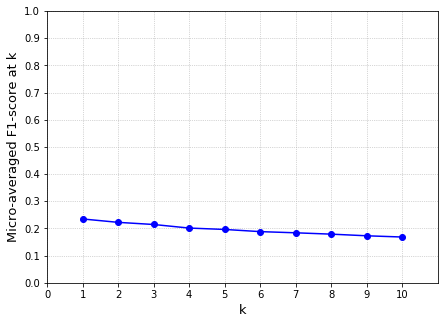

In [5]:
plt.clf()
img = plt.gcf()
ax = plt.gca()
validation_scores = [
validation micro-F1 @1: 0.17737556561085974
validation micro-F1 @2: 0.18476791347453808
validation micro-F1 @3: 0.18340348767288034
validation micro-F1 @4: 0.18190024825095916
validation micro-F1 @5: 0.17704561911658218
validation micro-F1 @6: 0.17075386012715713
validation micro-F1 @7: 0.1640838650865998
validation micro-F1 @8: 0.15989036089538602
validation micro-F1 @9: 0.1577396076837077
validation micro-F1 @10: 0.15500183217295713
]
plot_micro_f1_at_k(validation_scores,ax)
plt.gcf().set_size_inches(7,5)
plt.gca().legend_.remove()
plt.show()